## MSc Data Analytics - Capstone Project

#### Predictive Analysis in the Coffee Market: Using Deep Learning to predict coffee prices.
Student id: 2020274 Clarissa Cardoso


## Introduction
This notebook aims to analyse historical coffee price indices and develop a predictive model for future price trends. The focus is on using data from the ICO (International Coffee Organization), particularly indices like I-CIP, that combines prices of Colombian Milds, Other Milds, Brazilian Naturals, and Robustas.

### Dataset:
The dataset used in this analysis consists of historical coffee price data, with daily observations for business days. Prices are expressed in cents of USD per lb. 


The data utilized in this project is sourced from the International Coffee Organization's (ICO) Public Market Information, which provides the I-CIP values free of charge.

For the early stages of the experimentation, 1 year worth of data was available to collect, from 01Feb23 to 29Feb24, which is present on a separate notebook (2020274_capstone_EDA_Models 2.ipynb). In this notebook, recent data from March to September 2024 were added to expand insights and feed more datapoints to modelling stage. 


### Objectives:
1. Clean and preprocess the dataset for missing values and inconsistencies.
2. Explore the time-series behavior of coffee prices through visualizations.
3. Implement various forecasting models to predict future price trends, including traditional statistical models (e.g., ARIMA/Sarima) and deep learning algorithms (e.g., LSTM neural networks).
4. Compare model performance using key metrics (e.g., RMSE, MAE).


### Expected Outcome:
By the end of this notebook, we will identify the best forecasting model for coffee prices and present actionable insights based on the findings.

        Forecasting: generate forecasts for future I-CIP values using the best-performing model(s) and visualize the results to facilitate interpretation and decision-making.
- 1 day
- 5 days = 1 week
- 21 days = 1 month
(- 63 days = 3 months (1 quarter))

### Importing relevant libraries for the project

In [1]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)


## cheking if keras/tensorflow are correclty installed 

Keras version: 2.10.0
TensorFlow version: 2.10.0


In [2]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd #dataframes 
import numpy as np #linear algebra
import seaborn as sns #visualization
sns.set(color_codes=True)


import plotly.express as px
import plotly.graph_objects as go


import scipy.stats as stats #statistical resources

import matplotlib.pyplot as plt #visualisation 
%matplotlib inline 


from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl

from sklearn.model_selection import train_test_split # importing function to split the data training and test.
from sklearn.preprocessing import MinMaxScaler # Import the MinMaxScaler module from sklearn.preprocessing library
from sklearn.linear_model import LinearRegression # importing to performe linear regression. 
from sklearn.metrics import make_scorer, r2_score # Importing from Metrics module
from sklearn.preprocessing import StandardScaler # standardize the data
from sklearn import metrics # Metrics module from scikit-learn
from sklearn.model_selection import GridSearchCV # importing for hyperparameter tunning
from sklearn.metrics import mean_squared_error # importing mse
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #last update in python causing dead kernel wehn importing keras functions?
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.interpolate import interp1d

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# 1. Load data

For the early stages of this experimentation, 1 year worth of data was available to collect, from 01Feb23 to 29Feb24.

This section will review the original dataset compiled with data from feb 23 to feb 24.




A few thingsobserved when importing the raw files: 

- Column mismatch: Assuming all files have the same column names and order. This can lead to errors when merging DataFrames with different structures.



Since then, ICO has released additional months that will be included in the dataframe, considering the timeframe from march to september 2024 as a way to feed more data to the models. 


In [3]:
# Read the CSV file 
icip_data = pd.read_csv("icip_df.csv")

# View the first 5 rows
icip_data.head()

date   I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
0  2023-02-01  171.43           235.92       223.22         191.65    102.31   
1  2023-02-02  172.50           237.34       226.26         192.86    102.00   
2  2023-02-03  169.47           232.24       221.86         188.61    101.52   
3  2023-02-06  171.29           235.17       224.80         190.77    102.02   
4  2023-02-07  172.14           235.65       226.72         191.92    102.10   

   year  month  
0  2023      2  
1  2023      2  
2  2023      2  
3  2023      2  
4  2023      2

### Checking  additional data from March/24 to September/24 before combining to main dataframe 

In [4]:
import os
# List all the files in the folder
os.listdir("icip_24") 

['I-CIP_September_2024.csv',
 'I-CIP_August_2024.csv',
 'I-CIP_April_2024.csv',
 'I-CIP_March_2024.csv',
 'I-CIP_May_2024.csv',
 'I-CIP_July_2024.csv',
 'I-CIP_June_2024.csv']

In [5]:
#create for loop to import csv files from the folder with less comands.

# create an empty list to store dfs
dataframes = []

# path to folder where csv files are (in this case same directory)
folder_path = "icip_24"


# to import CSV starting from the third row, skipping the first two
def import_csv(filepath):
    return pd.read_csv(filepath, skiprows=2)

# Iterate through files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  # Only consider CSV files
        file_path = os.path.join(folder_path, file)  # Construct the full file path
        dataframes.append(import_csv(file_path))  # Read CSV and append to list

In [6]:
#check the lenght of the directory, how many files exist in the new folder
len(dataframes)

7

Chcking the heading of the files to undertand how features are allocated in this first stage before combining the new 7 months to main dataframe

The same issue appears with the heading names. So this time around it was decided to ignore the first 2 rows to avoid the unnamed header and only collect the data 

Unnamed: 0	Unnamed: 1	Colombian	Unnamed: 3	Brazilian	Unnamed: 5
0	NaN	I-CIP	NaN	Other Milds	NaN	Robusta


In [9]:
#check if order of files correspond with the directory list, testing if loop is working
dataframes[5].head()

Unnamed: 0  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5
0     01-Jul      224.77  248.87      245.94    227.53      202.00
1     02-Jul      228.21  251.41      249.08    232.47      204.63
2     03-Jul      225.51  248.18      245.85    228.99      203.10
3     04-Jul      227.04  247.42      246.27    228.97      207.38
4     05-Jul      230.76  251.20      252.03    234.53      208.30

In [8]:
print(dataframes)
#list of all dataframes

[   Unnamed: 0  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5
0      02-Sep      241.71  265.38      260.21    239.79      224.69
1      03-Sep      241.20  264.48      259.50    239.13      224.54
2      04-Sep      245.35  266.69      260.63    241.03      233.05
3      05-Sep      249.73  269.06      268.61    247.93      233.82
4      06-Sep      243.88  262.39      261.53    241.58      229.40
5      09-Sep      247.47  269.31      268.28    246.38      228.99
6      10-Sep      251.18  272.41      271.39    250.57      232.83
7      11-Sep      252.78  272.00      270.98    250.20      237.98
8      12-Sep      255.22  273.63      273.58    252.47      240.75
9      13-Sep      265.67  283.72      283.53    262.78      251.73
10     16-Sep      264.57  282.28      282.63    261.62      250.68
11     17-Sep      269.45  288.40      288.74    267.76      253.35
12     18-Sep      269.47  288.21      288.56    267.49      253.80
13     19-Sep      265.09  283.29      284.33  

To continue the project is necessary to make 2 adjustments in the second directory:
- change the date format from " 06-Jun" to '%Y-%m-%d' format and apply this to all files in the "Unnamed: 0" collum which corresponds to date. This will enable a more smooth combination of the 2 dfs once all dates mantain the correct format. 

In [10]:
# Test: print the first DataFrame to check if the transformation worked
print(dataframes[5].head())

  Unnamed: 0  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5
0     01-Jul      224.77  248.87      245.94    227.53      202.00
1     02-Jul      228.21  251.41      249.08    232.47      204.63
2     03-Jul      225.51  248.18      245.85    228.99      203.10
3     04-Jul      227.04  247.42      246.27    228.97      207.38
4     05-Jul      230.76  251.20      252.03    234.53      208.30


In [11]:
# Function to transform the 'Unnamed: 0' date column for each DataFrame in the list and reorder columns
def transform_date(dataframes, year):
    month_mapping = {
        'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
        'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
        'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    
    # Iterate over each DataFrame in the list
    for i in range(len(dataframes)):
        df = dataframes[i]
        
        # Print the columns to inspect if 'Unnamed: 0' exists or if the name is different
        print(f"Columns in DataFrame {i}: {df.columns}")
        
        # Check if 'Unnamed: 0' exists, otherwise handle the column name differently
        if 'Unnamed: 0' in df.columns:
            # Apply the transformation to the 'Unnamed: 0' column to create full date strings
            df['date'] = df['Unnamed: 0'].apply(
                lambda x: '-'.join([str(year), month_mapping[x.split('-')[1]], x.split('-')[0]])
            )
            
            # Convert the 'Date' column to datetime format
            df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
            
            # Drop the original 'Unnamed: 0' column
            df.drop(columns=['Unnamed: 0'], inplace=True)
            
            # Reorder columns to place 'Date' first
            columns = ['date'] + [col for col in df.columns if col != 'date']
            dataframes[i] = df[columns]  # Replace the DataFrame with the reordered one
        else:
            print(f"'Unnamed: 0' column not found in DataFrame {i}")
    
    return dataframes

# Apply the function to the list of DataFrames
dataframes = transform_date(dataframes, 2024)

# Test: print the first DataFrame to check if the column reordering worked
print(dataframes[0].head())

Columns in DataFrame 0: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 1: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 2: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 3: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 4: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 5: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
Columns in DataFrame 6: Index(['Unnamed: 0', 'Unnamed: 1', 'Milds', 'Unnamed: 3', 'Naturals',
       'Unnamed: 5'],
      dtype='object')
        date  Unnamed: 1   Milds  

## Checking the right date format was saved and adding year/month columns to match main df

In [12]:
# Function to add year and month columns to each DataFrame in the list
def add_year_month_columns(dataframes):
    for i in range(len(dataframes)):
        df = dataframes[i]
        
        # Extract the year and month from the 'Date' column
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        
        # Replace the DataFrame in the list with the new columns added
        dataframes[i] = df
        
    return dataframes

# Apply the function to the list of DataFrames
dataframes = add_year_month_columns(dataframes)

# checking if transformation worked in the dataframes list:
dataframes[0].head()

date  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5  year  \
0 2024-09-02      241.71  265.38      260.21    239.79      224.69  2024   
1 2024-09-03      241.20  264.48      259.50    239.13      224.54  2024   
2 2024-09-04      245.35  266.69      260.63    241.03      233.05  2024   
3 2024-09-05      249.73  269.06      268.61    247.93      233.82  2024   
4 2024-09-06      243.88  262.39      261.53    241.58      229.40  2024   

   month  
0      9  
1      9  
2      9  
3      9  
4      9

### Define chronologiav order for dataframe

In [13]:
# Define the list of DataFrames in the desired order
dfs_in_order = [dataframes[3],dataframes[2],dataframes[4],dataframes[6],dataframes[5],dataframes[1],dataframes[0]]

# Concatenate the DataFrames
merged_df = pd.concat(dfs_in_order,ignore_index=True)

# Display the merged DataFrame
merged_df

date  Unnamed: 1   Milds  Unnamed: 3  Naturals  Unnamed: 5  year  \
0   2024-03-01      181.39  206.30      204.99    183.44      157.54  2024   
1   2024-03-04      183.10  209.76      207.30    185.63      157.91  2024   
2   2024-03-05      181.97  206.67      205.81    183.35      158.63  2024   
3   2024-03-06      185.77  209.44      208.59    186.12      164.27  2024   
4   2024-03-07      190.75  215.48      214.71    192.05      167.42  2024   
..         ...         ...     ...         ...       ...         ...   ...   
147 2024-09-24      269.83  289.78      291.26    267.94      252.30  2024   
148 2024-09-25      270.09  291.55      293.03    270.32      249.36  2024   
149 2024-09-26      272.70  296.96      296.29    274.52      249.30  2024   
150 2024-09-27      268.97  292.23      291.25    269.86      247.45  2024   
151 2024-09-30      270.37  294.02      292.80    271.99      248.00  2024   

     month  
0        3  
1        3  
2        3  
3        3  
4        3  
..     ...  
147      9  
148      9  
149      9  
150      9  
151      9  

[152 rows x 8 columns]

In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        152 non-null    datetime64[ns]
 1   Unnamed: 1  152 non-null    float64       
 2   Milds       152 non-null    float64       
 3   Unnamed: 3  152 non-null    float64       
 4   Naturals    152 non-null    float64       
 5   Unnamed: 5  152 non-null    float64       
 6   year        152 non-null    int64         
 7   month       152 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 9.6 KB


from the info function displays the new data contains 152 observations across 8 columss from march 24 to september 24.
the first colum shows dates in datetime format, followed by each category of coffee as well as the index values as floats. the added year and month number of each observation is in integer format.


### Rename column names prior to merging both datasets

This will enable to combine previous data from original dataset to have a bigger pool of observations to feed more data in the modeling part. Is expected the final dataset to combine data from feb/23 to sep/24

- df1 = icip_data > contains the original dataset (Feb 2023 - Feb 2024)
- df2 = merged_df > contains the new dataset (Mar 2024 - Sep 2024)



In [15]:
df1 = icip_data
df2 = merged_df


In [16]:
df1

date   I-CIP  colombian_milds  other_milds  brazilian_nat  \
0    2023-02-01  171.43           235.92       223.22         191.65   
1    2023-02-02  172.50           237.34       226.26         192.86   
2    2023-02-03  169.47           232.24       221.86         188.61   
3    2023-02-06  171.29           235.17       224.80         190.77   
4    2023-02-07  172.14           235.65       226.72         191.92   
..          ...     ...              ...          ...            ...   
274  2024-02-23  177.80           204.48       202.46         183.74   
275  2024-02-26  177.48           204.12       202.11         183.48   
276  2024-02-27  180.23           207.11       205.10         186.34   
277  2024-02-28  179.12           206.01       204.00         185.39   
278  2024-02-29  180.11           207.67       205.52         186.73   

     robustas  year  month  
0      102.31  2023      2  
1      102.00  2023      2  
2      101.52  2023      2  
3      102.02  2023      2  
4      102.10  2023      2  
..        ...   ...    ...  
274    149.40  2024      2  
275    149.08  2024      2  
276    151.51  2024      2  
277    150.23  2024      2  
278    150.40  2024      2  

[279 rows x 8 columns]

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        152 non-null    datetime64[ns]
 1   Unnamed: 1  152 non-null    float64       
 2   Milds       152 non-null    float64       
 3   Unnamed: 3  152 non-null    float64       
 4   Naturals    152 non-null    float64       
 5   Unnamed: 5  152 non-null    float64       
 6   year        152 non-null    int64         
 7   month       152 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 9.6 KB


In [18]:
# Ensure that the 'Date' column in both df1 and df2 is in datetime format
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

# Rename the columns in df2 to match the structure of df1
df2.columns = ['date', 'I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas', 'year', 'month']

# Concatenate df1 and df2 into a single DataFrame
combined_df = pd.concat([df1, df2], ignore_index=True)

# Sort by the 'Date' column to ensure chronological order
combined_df = combined_df.sort_values(by='date').reset_index(drop=True)

# Optionally, save the final DataFrame to a CSV file
combined_df.to_csv('final_combined_data.csv', index=False)

# Test: print the first few rows to verify the result
print(combined_df.head())

        date   I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
0 2023-02-01  171.43           235.92       223.22         191.65    102.31   
1 2023-02-02  172.50           237.34       226.26         192.86    102.00   
2 2023-02-03  169.47           232.24       221.86         188.61    101.52   
3 2023-02-06  171.29           235.17       224.80         190.77    102.02   
4 2023-02-07  172.14           235.65       226.72         191.92    102.10   

   year  month  
0  2023      2  
1  2023      2  
2  2023      2  
3  2023      2  
4  2023      2  


In [19]:
combined_df

date   I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
0   2023-02-01  171.43           235.92       223.22         191.65    102.31   
1   2023-02-02  172.50           237.34       226.26         192.86    102.00   
2   2023-02-03  169.47           232.24       221.86         188.61    101.52   
3   2023-02-06  171.29           235.17       224.80         190.77    102.02   
4   2023-02-07  172.14           235.65       226.72         191.92    102.10   
..         ...     ...              ...          ...            ...       ...   
426 2024-09-24  269.83           289.78       291.26         267.94    252.30   
427 2024-09-25  270.09           291.55       293.03         270.32    249.36   
428 2024-09-26  272.70           296.96       296.29         274.52    249.30   
429 2024-09-27  268.97           292.23       291.25         269.86    247.45   
430 2024-09-30  270.37           294.02       292.80         271.99    248.00   

     year  month  
0    2023      2  
1    2023      2  
2    2023      2  
3    2023      2  
4    2023      2  
..    ...    ...  
426  2024      9  
427  2024      9  
428  2024      9  
429  2024      9  
430  2024      9  

[431 rows x 8 columns]

The combined dataset on the correct stucture can help to make better explorations on the next sections. 

# 2. Exploratory Data Analysis


In [20]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             431 non-null    datetime64[ns]
 1   I-CIP            431 non-null    float64       
 2   colombian_milds  431 non-null    float64       
 3   other_milds      431 non-null    float64       
 4   brazilian_nat    431 non-null    float64       
 5   robustas         431 non-null    float64       
 6   year             431 non-null    int64         
 7   month            431 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 27.1 KB


### Check fo rmissing values and summary statisctis 


In [21]:
# Missing values
print(combined_df.isnull().sum())

# Get summary statistics for numerical columns
print(combined_df.describe())

date               0
I-CIP              0
colombian_milds    0
other_milds        0
brazilian_nat      0
robustas           0
year               0
month              0
dtype: int64
            I-CIP  colombian_milds  other_milds  brazilian_nat    robustas  \
count  431.000000       431.000000   431.000000     431.000000  431.000000   
mean   187.857285       222.166218   220.083712     193.324548  152.914269   
std     31.780462        27.809617    27.193786      30.685967   41.248259   
min    145.990000       178.820000   174.970000     147.660000  101.520000   
25%    163.515000       197.635000   198.805000     170.085000  121.800000   
50%    177.480000       220.390000   216.090000     187.210000  134.210000   
75%    214.190000       243.220000   239.560000     216.060000  190.000000   
max    272.700000       296.960000   296.290000     274.520000  253.800000   

              year       month  
count   431.000000  431.000000  
mean   2023.452436    6.083527  
std       0.49831

### Plotting trends overtime to begin understanding how this new dataset is presented

## 2.1 Prices plots

###  a. ICO Composite Indicator Price (I-CIP) is the main feature to be used for the predictions


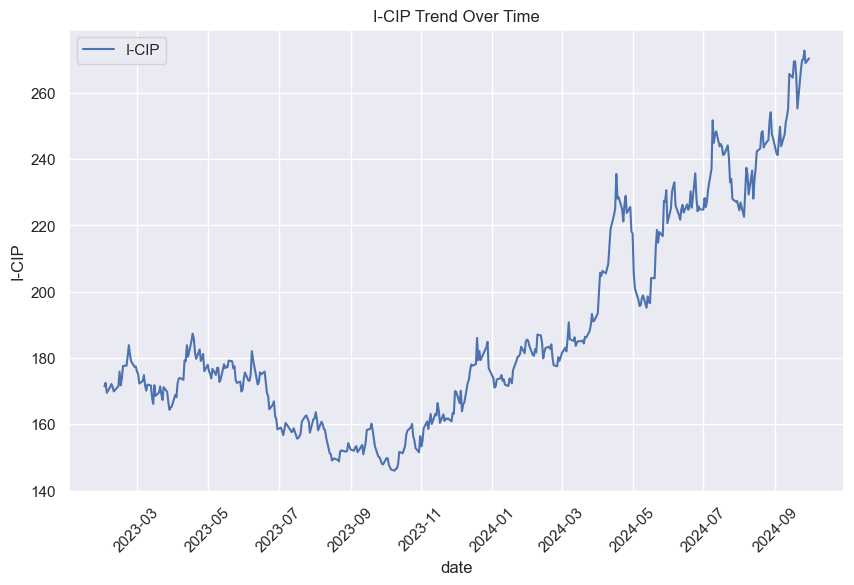

In [22]:
import matplotlib.pyplot as plt

# Plot I-CIP over time
plt.figure(figsize=(10, 6))
plt.plot(combined_df['date'], combined_df['I-CIP'], label='I-CIP')
plt.xlabel('date')
plt.ylabel('I-CIP')
plt.title('I-CIP Trend Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## b. Comparing the different categories over time:

Each category has a different weight to calculate the final composite. **(get data on this)**


In [23]:
# Plot other categories of coffee over time
plt.figure(figsize=(10, 6))
plt.plot(combined_df['date'], combined_df['I-CIP'], label='I-CIP')
plt.plot(combined_df['date'], combined_df['colombian_milds'], label='Colombian Milds')
plt.plot(combined_df['date'], combined_df['other_milds'], label='Other Milds')
plt.plot(combined_df['date'], combined_df['brazilian_nat'], label='Brazilian Naturals')
plt.plot(combined_df['date'], combined_df['robustas'], label='Robustas')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Coffee Types Trend Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## c. Compare ICIP to each coffee category over time
changing labels for date axis for easier visualisation (ie 2023-03 to MAR 2023)

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Define only the columns you want to plot (excluding the last two columns)
columns_to_plot = ['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas']

plt.figure(figsize=(10, 6))

# Iterate over the selected columns and plot each one
for column in columns_to_plot:
    plt.plot(combined_df['date'], combined_df[column], label=column)

# Customize x-axis to show months (use date format for better readability)
plt.xlabel('Month')
plt.ylabel('Price (USD)')
plt.title('Price Fluctuations of ICO Composite Indicator and Coffee Groups Over Time')
plt.legend()

# Format the x-axis labels to show the month name with better spacing
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Shows every 3rd month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)  # Rotate for better readability

# Show plot
plt.show()

### 2.2 Setting the date column as index:


In [25]:
#create new variable for merged_df and reseting date as the index for building time series in later stages
# Set 'date' column as index
combined_df.set_index('date', inplace=True)

#check output
icip_df = combined_df
icip_df.head()

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                        
2023-02-01  171.43           235.92       223.22         191.65    102.31   
2023-02-02  172.50           237.34       226.26         192.86    102.00   
2023-02-03  169.47           232.24       221.86         188.61    101.52   
2023-02-06  171.29           235.17       224.80         190.77    102.02   
2023-02-07  172.14           235.65       226.72         191.92    102.10   

            year  month  
date                     
2023-02-01  2023      2  
2023-02-02  2023      2  
2023-02-03  2023      2  
2023-02-06  2023      2  
2023-02-07  2023      2

### 2.2.1 Checking the range of dataset: 


With the dates as indext we can check the range of the dataset: 

- 607 days however the data collected is at a frequency of BUSINESS DAYS, excluding weekends and holidays, which would account for the difference between the total days (607) and the number of observations (431).

In [26]:
## Checking how many days are present in the dataset

print(f'Dataframe contains prices between {icip_df.index.min()} {icip_df.index.max()}')
print(f'Total Days = {icip_df.index.max() - icip_df.index.min()} days')

Dataframe contains prices between 2023-02-01 00:00:00 2024-09-30 00:00:00
Total Days = 607 days 00:00:00 days


### Once the date is set as index, is possible to measure the range an frequency of data. 




In [27]:
# making sure the index is set at datetime 
icip_df.index = pd.to_datetime(icip_df.index)

In [28]:
### From the range, confirm the frequency of the index
print(icip_df.index.freq)

None


A freq marked as 'None' makes python treat the date as irregular. Manually setting the frquency as Business days since the frequancy is not really defined.
This can have a series of benefits:
- Align  data with time-based operations.
- Perform accurate rolling calculations and time series decomposition.
- Handle missing data systematically.
- Use advanced time series models and resampling.


https://pandas.pydata.org/pandas-docs/version/0.16/timeseries.html

In [29]:
icip_df = icip_df.asfreq('B')  # B stands for Business Days

In [30]:
### From the range, confirm the frequency of the index
print(icip_df.index.freq)

<BusinessDay>


### 2.2.1

### a. Checking monthly seasonality



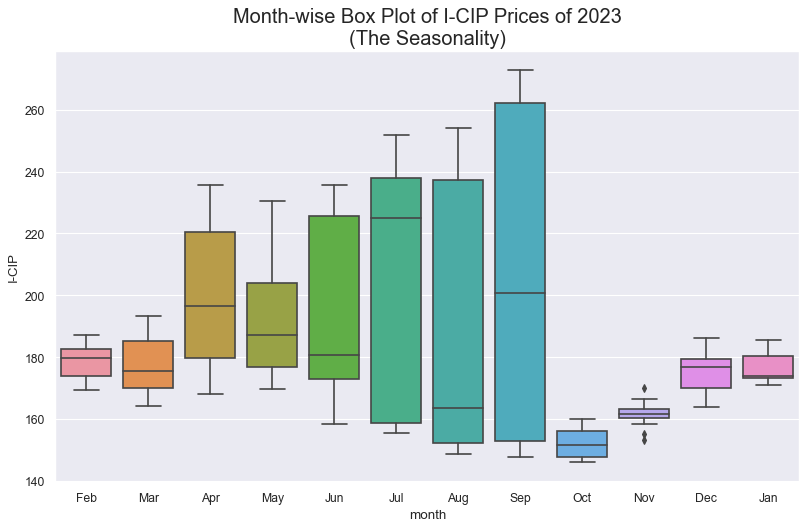

In [31]:
# Extract year and month from the index

## plot only for 2023 and plot a separate for 2024
#are variations in price the same in both year????




icip_df['year'] = icip_df.index.year
icip_df['month'] = icip_df.index.month_name().str[:3]  # This will give  the three-letter month abbreviation.

# Draw Plot
plt.figure(figsize=(12, 7), dpi=80)
sns.boxplot(x='month', y='I-CIP', data=icip_df)

# Set Title
plt.title('Month-wise Box Plot of I-CIP Prices of 2023\n(The Seasonality)', fontsize=18)

# Show the plot
plt.show()

In [32]:
icip_df

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                        
2023-02-01  171.43           235.92       223.22         191.65    102.31   
2023-02-02  172.50           237.34       226.26         192.86    102.00   
2023-02-03  169.47           232.24       221.86         188.61    101.52   
2023-02-06  171.29           235.17       224.80         190.77    102.02   
2023-02-07  172.14           235.65       226.72         191.92    102.10   
...            ...              ...          ...            ...       ...   
2024-09-24  269.83           289.78       291.26         267.94    252.30   
2024-09-25  270.09           291.55       293.03         270.32    249.36   
2024-09-26  272.70           296.96       296.29         274.52    249.30   
2024-09-27  268.97           292.23       291.25         269.86    247.45   
2024-09-30  270.37           294.02       292.80         271.99    248.00   

            year month  
date                    
2023-02-01  2023   Feb  
2023-02-02  2023   Feb  
2023-02-03  2023   Feb  
2023-02-06  2023   Feb  
2023-02-07  2023   Feb  
...          ...   ...  
2024-09-24  2024   Sep  
2024-09-25  2024   Sep  
2024-09-26  2024   Sep  
2024-09-27  2024   Sep  
2024-09-30  2024   Sep  

[434 rows x 7 columns]

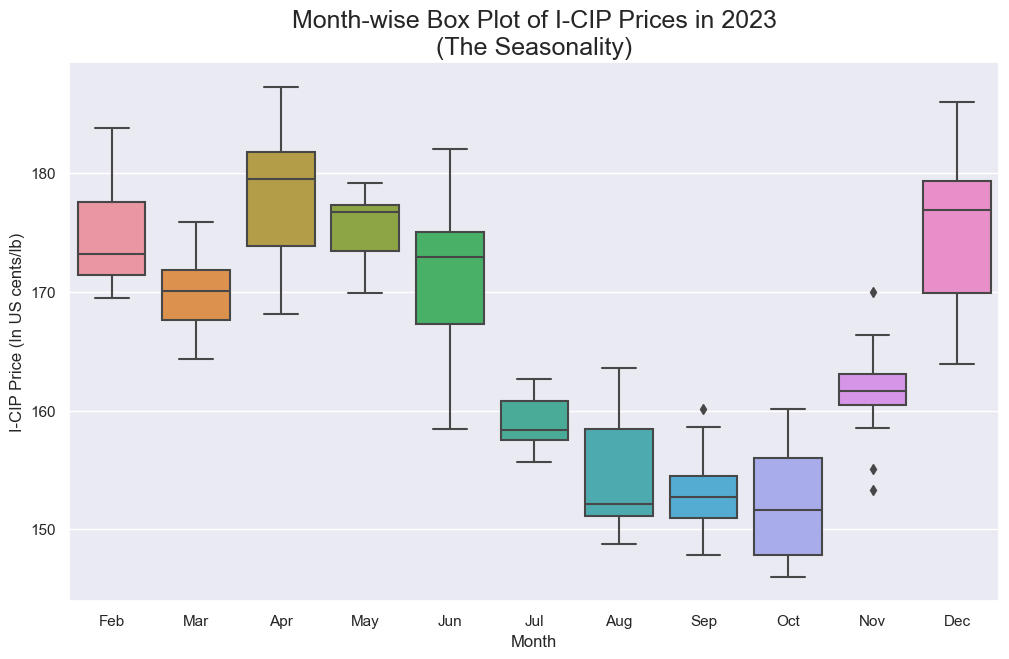

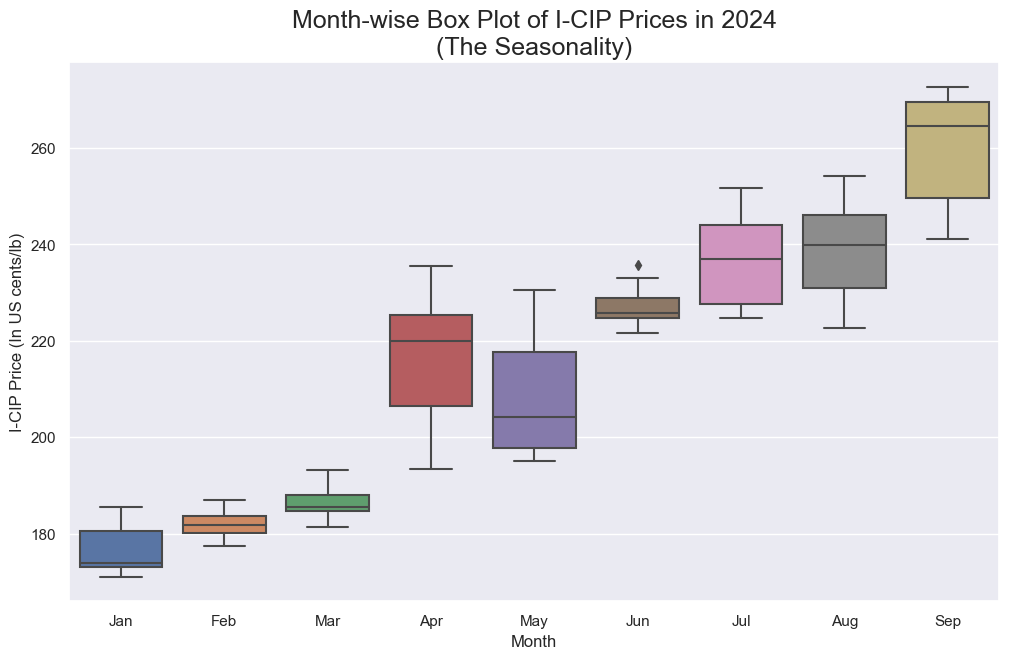

In [33]:
# Filter data by year
df_2023 = icip_df[icip_df['year'] == 2023]
df_2024 = icip_df[icip_df['year'] == 2024]

# Plot for 2023
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='I-CIP', data=df_2023, order=['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Month-wise Box Plot of I-CIP Prices in 2023\n(The Seasonality)', fontsize=18)
plt.xlabel('Month')
plt.ylabel('I-CIP Price (In US cents/lb)')
plt.show()

# Plot for 2024 (up to September)
plt.figure(figsize=(12, 7))
sns.boxplot(x='month', y='I-CIP', data=df_2024, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])
plt.title('Month-wise Box Plot of I-CIP Prices in 2024\n(The Seasonality)', fontsize=18)
plt.xlabel('Month')
plt.ylabel('I-CIP Price (In US cents/lb)')
plt.show()

### Year-over-Year Monthly Comparison:

This plot aims to compare the avarage of icip prices in 2023 and 2024, to highlight differences in each year.

Overall, the year of 24 is represented by higher average, confirming the upward trend seen in line plots in item c. 

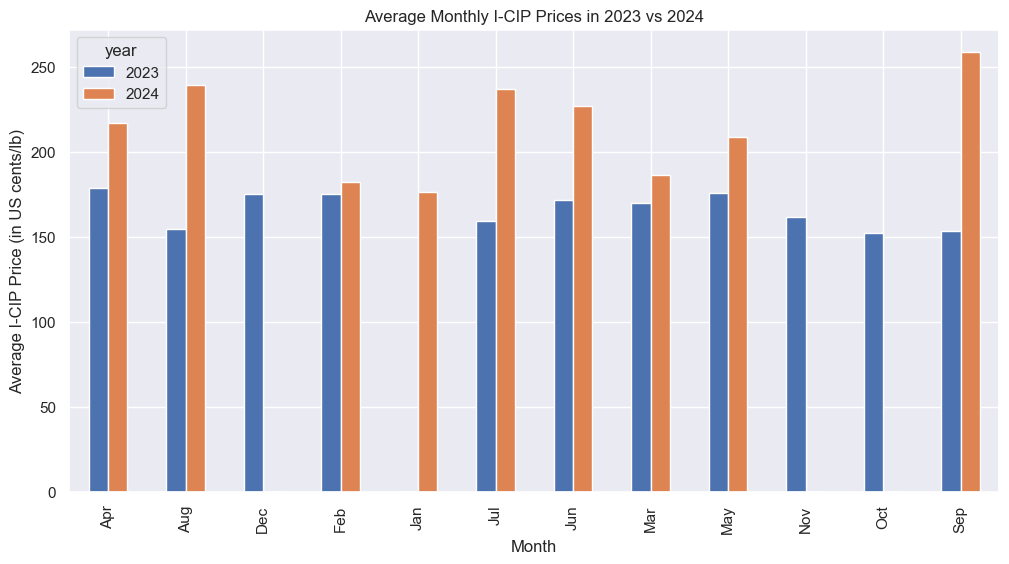

In [34]:
# Monthly average comparison
monthly_avg = icip_df.groupby(['year', 'month'])['I-CIP'].mean().unstack(level=0)
monthly_avg.plot(kind='bar', figsize=(12, 6))
plt.title('Average Monthly I-CIP Prices in 2023 vs 2024')
plt.xlabel('Month')
plt.ylabel('Average I-CIP Price (in US cents/lb)')
plt.show()

###  Monthly Average I-CIP Prices with Regional Harvest Annotations

In [35]:
import calendar

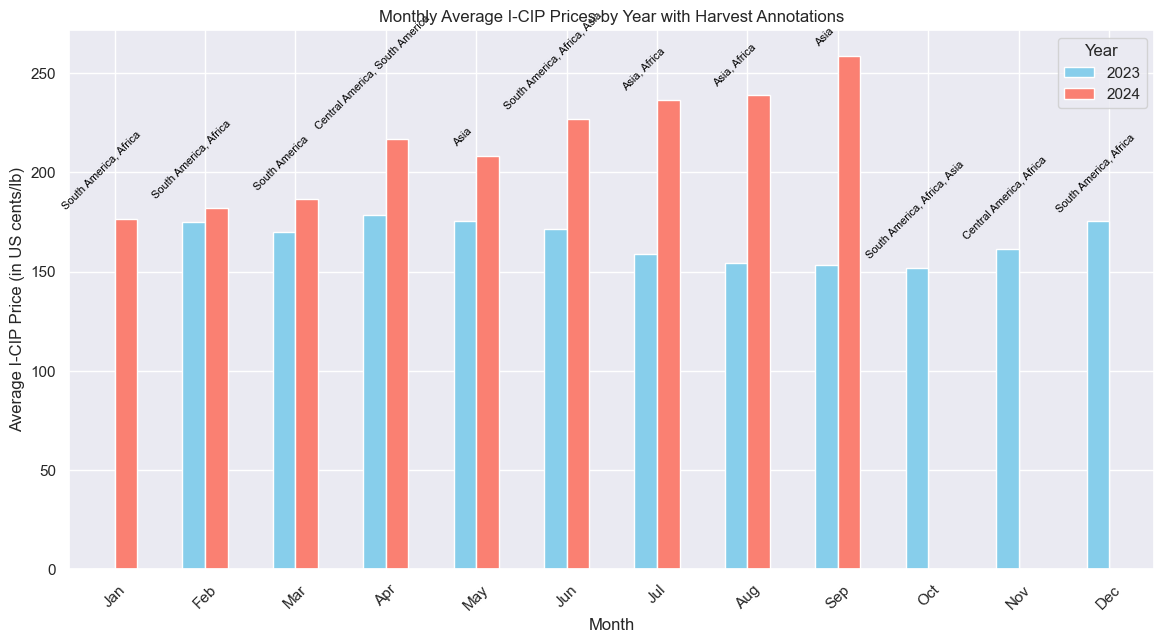

In [36]:
# Set the month order to ensure chronological sorting
month_order = list(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']
icip_df['month'] = pd.Categorical(icip_df['month'], categories=month_order, ordered=True)

# Group by both year and month to keep month names in chronological order
monthly_avg_df = icip_df.groupby([icip_df.index.year, 'month'])['I-CIP'].mean().unstack(level=0)

# Create the plot with annotations of harvest 
plt.figure(figsize=(14, 7))
monthly_avg_df.plot(kind='bar', color=['skyblue', 'salmon'], ax=plt.gca())
plt.xlabel('Month')
plt.ylabel('Average I-CIP Price (in US cents/lb)')
plt.title('Monthly Average I-CIP Prices by Year with Harvest Annotations')

# Annotate months with regional harvests
harvest_annotations = {
    'Jan': 'South America, Africa',
    'Feb': 'South America, Africa',
    'Mar': 'South America',
    'Apr': 'Central America, South America',
    'May': 'Asia',
    'Jun': 'South America, Africa, Asia',
    'Jul': 'Asia, Africa',
    'Aug': 'Asia, Africa',
    'Sep': 'Asia',
    'Oct': 'South America, Africa, Asia',
    'Nov': 'Central America, Africa',
    'Dec': 'South America, Africa'
}

# Add annotations at 45-degree angle for readability
for month_idx, (month, regions) in enumerate(harvest_annotations.items()):
    plt.text(month_idx - 0.15, monthly_avg_df.loc[month].max() + 5, 
             regions, ha='center', rotation=45, color='black', fontsize=8)

# Adjust x-axis labels
plt.xticks(rotation=45)
plt.legend(title="Year", loc="upper right")
plt.show()

# harverst dates extracted from 
#Source: https://coffeehunter.com/coffee-seasonality/ accessed on 30/10
# https://www.fairmountaincoffee.com/category-s/102.htm accessedon 30/10

#### Heatmap of Monthly Price Averages 

The heatmat below aims to identify months where prices tend to dip or spike, then cross-reference with known harvest periods. The color intensity provides a quick overview of price levels each month.

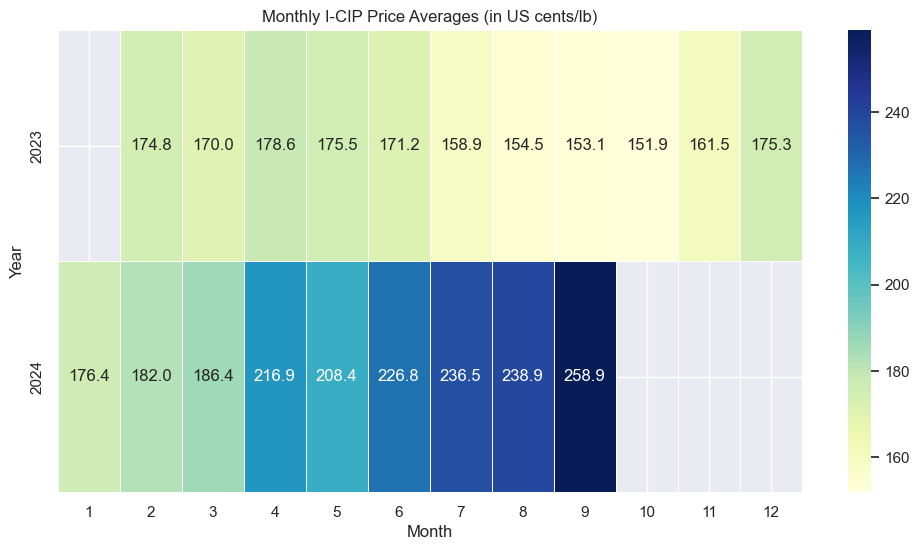

In [37]:
# Create a DataFrame for monthly averages
monthly_avg_df = icip_df.groupby([icip_df.index.year, icip_df.index.month])['I-CIP'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_avg_df, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=0.5)
plt.title('Monthly I-CIP Price Averages (in US cents/lb)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

In [38]:
# Define harvest months based on regions
harvest_months = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]  # months with harvests in at least one region
icip_df['harvest_period'] = icip_df.index.month.isin(harvest_months).map({True: 'Harvest', False: 'Non-Harvest'})

plt.figure(figsize=(10, 6))
sns.boxplot(x='harvest_period', y='I-CIP', data=icip_df, palette='Set2')
plt.title('I-CIP Price Distribution During Harvest vs Non-Harvest Periods')
plt.xlabel('Period')
plt.ylabel('I-CIP Price (in US cents/lb)')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'map'

## d. Value distribution across categories



###### plot monthy only by category 

In [39]:
# copy of the original DataFrame without 'year' and 'month' columns
copy = icip_df.drop(columns=['year', 'month']).copy()

In [40]:
import plotly.graph_objects as go

# Define colors from the Set2 palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']

# Create boxplot traces
box_traces = []
for i, column in enumerate(copy.columns):
    box_trace = go.Box(y=copy[column], name=column, marker=dict(color=colors[i]))
    box_traces.append(box_trace)

# Create layout
layout = go.Layout(title='Boxplot by Group', yaxis=dict(title='Value'), xaxis=dict(title='Variable'))

# Create figure
fig = go.Figure(data=box_traces, layout=layout)

# Show plot
fig.show()

colombian_milds and brazilian_nat have similar median values but different spreads of data, suggesting that the two groups exhibit relatively stable prices.


robustas has the largest range of prices, which could indicate greater market volatility or variability in this coffee category.


I-CIP shows a balanced range, but it’s positioned lower than both colombian_milds and brazilian_nat, which are premium categories.

In [41]:
icip_df.describe()

I-CIP  colombian_milds  other_milds  brazilian_nat    robustas  \
count  431.000000       431.000000   431.000000     431.000000  431.000000   
mean   187.857285       222.166218   220.083712     193.324548  152.914269   
std     31.780462        27.809617    27.193786      30.685967   41.248259   
min    145.990000       178.820000   174.970000     147.660000  101.520000   
25%    163.515000       197.635000   198.805000     170.085000  121.800000   
50%    177.480000       220.390000   216.090000     187.210000  134.210000   
75%    214.190000       243.220000   239.560000     216.060000  190.000000   
max    272.700000       296.960000   296.290000     274.520000  253.800000   

              year  
count   434.000000  
mean   2023.451613  
std       0.498228  
min    2023.000000  
25%    2023.000000  
50%    2023.000000  
75%    2024.000000  
max    2024.000000

the last 2 columns were only added to facilite some of the montkly plots, ill copy the main data as a separate dataframe for more statistical measurements

In [42]:
copy.describe()

I-CIP  colombian_milds  other_milds  brazilian_nat    robustas
count  431.000000       431.000000   431.000000     431.000000  431.000000
mean   187.857285       222.166218   220.083712     193.324548  152.914269
std     31.780462        27.809617    27.193786      30.685967   41.248259
min    145.990000       178.820000   174.970000     147.660000  101.520000
25%    163.515000       197.635000   198.805000     170.085000  121.800000
50%    177.480000       220.390000   216.090000     187.210000  134.210000
75%    214.190000       243.220000   239.560000     216.060000  190.000000
max    272.700000       296.960000   296.290000     274.520000  253.800000

### Comparing mean values betrween categories


In [43]:
# Bar plot
plt.figure(figsize=(10, 6))
copy.mean().plot(kind='bar', color='skyblue')
plt.title('Mean Values of Groups')
plt.xlabel('Variables')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.show()

## 2.2.2 Checking correlation across categories

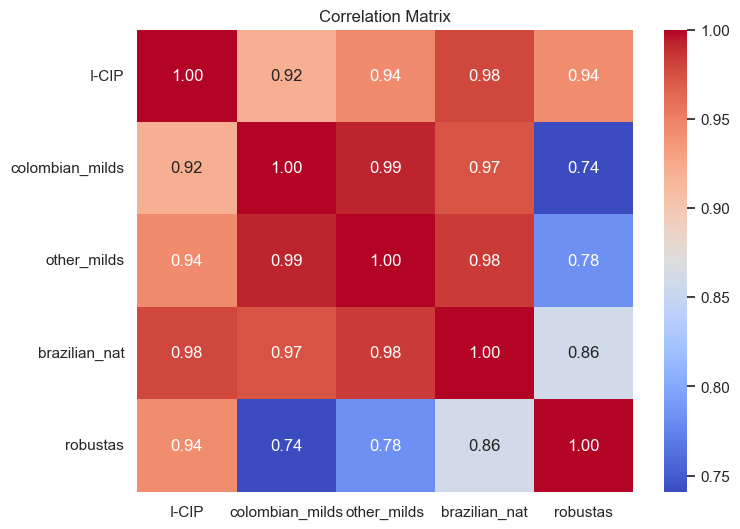

In [44]:
# Compute the correlation matrix
correlation_matrix = copy.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


ICO Composite Indicator Price (I-CIP) is calculated using a weighted average of four coffee groups: Colombian Milds, Other Milds, Brazilian Naturals, and Robustas, with each group contributing a specific weight to the calculation:

- Colombian Milds: 12%
- Other Milds: 21%
- Brazilian Naturals: 30%
- Robustas: 37%


In [45]:
print(copy.columns)

Index(['I-CIP', 'colombian_milds', 'other_milds', 'brazilian_nat', 'robustas'], dtype='object')


In [46]:
# Calculate the weighted I-CIP
copy['weighted_I-CIP'] = (0.12 * copy['colombian_milds'] +
                                 0.21 * copy['other_milds'] +
                                 0.30 * copy['brazilian_nat'] +
                                 0.37 * copy['robustas'])

# Compare weighted I-CIP with actual I-CIP
plt.figure(figsize=(10, 6))
plt.plot(copy.index, copy['I-CIP'], label='Actual I-CIP')
plt.plot(copy.index, copy['weighted_I-CIP'], label='Weighted I-CIP', linestyle='--')
plt.xlabel('Date')
plt.ylabel('I-CIP')
plt.title('Actual I-CIP vs Weighted I-CIP')
plt.legend()
plt.show()

#### Lag plots
understanding the entropy of icip prices and how correlated they are

the scatter plot bellow shows the relationship between observations and their lags.
"as the lag increases, the correlation between the time series and its lags generally decreases."

Some sort of autocorrelation in the data is visible in lag 1, (t+1). A strong linear relationship indicates a high correlation between an observation and its immediate predecessor. a similar pattern is observed in lag2, with a few datapoints begining to get apart. Lags 3 and 4 are already more spreaded, meaning the correlation between values is also decreasing as the interval between lags grow.

<function matplotlib.pyplot.show(close=None, block=None)>

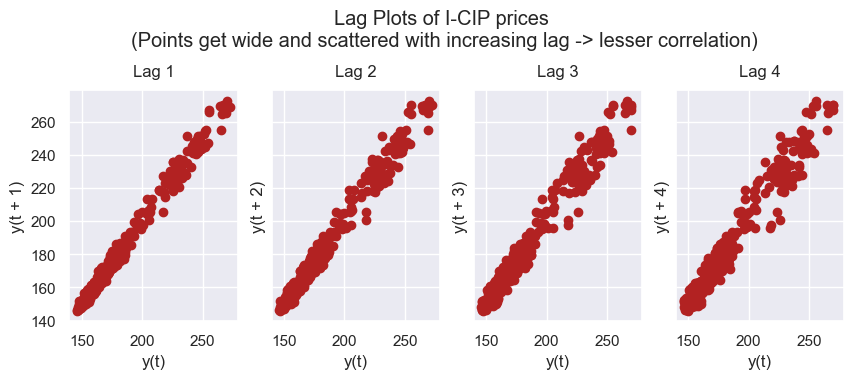

In [48]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

lp = icip_df['I-CIP']

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(lp, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

    
fig.suptitle('Lag Plots of I-CIP prices \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

plt.show

In [47]:
icip_df

I-CIP  colombian_milds  other_milds  brazilian_nat  robustas  \
date                                                                        
2023-02-01  171.43           235.92       223.22         191.65    102.31   
2023-02-02  172.50           237.34       226.26         192.86    102.00   
2023-02-03  169.47           232.24       221.86         188.61    101.52   
2023-02-06  171.29           235.17       224.80         190.77    102.02   
2023-02-07  172.14           235.65       226.72         191.92    102.10   
...            ...              ...          ...            ...       ...   
2024-09-24  269.83           289.78       291.26         267.94    252.30   
2024-09-25  270.09           291.55       293.03         270.32    249.36   
2024-09-26  272.70           296.96       296.29         274.52    249.30   
2024-09-27  268.97           292.23       291.25         269.86    247.45   
2024-09-30  270.37           294.02       292.80         271.99    248.00   

            year month  
date                    
2023-02-01  2023   Feb  
2023-02-02  2023   Feb  
2023-02-03  2023   Feb  
2023-02-06  2023   Feb  
2023-02-07  2023   Feb  
...          ...   ...  
2024-09-24  2024   Sep  
2024-09-25  2024   Sep  
2024-09-26  2024   Sep  
2024-09-27  2024   Sep  
2024-09-30  2024   Sep  

[434 rows x 7 columns]

In [51]:
# Define the number of lags for 1 month
number_of_lags = 21

# Create subplots with 3 columns
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate a lag plot for each lag
for i in range(1, number_of_lags + 1):
    lag_plot(icip_df['I-CIP'], lag=i, ax=axes[i-1])
    axes[i-1].set_title(f'Lag {i}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Rolling average / Rolling standard deviation


Rolling Mean: The rolling mean is the average of the previous observation window, where the window consists of a series of values from the time series data. Computing the mean for each ordered window. This can significantly help minimize noise in time series data.

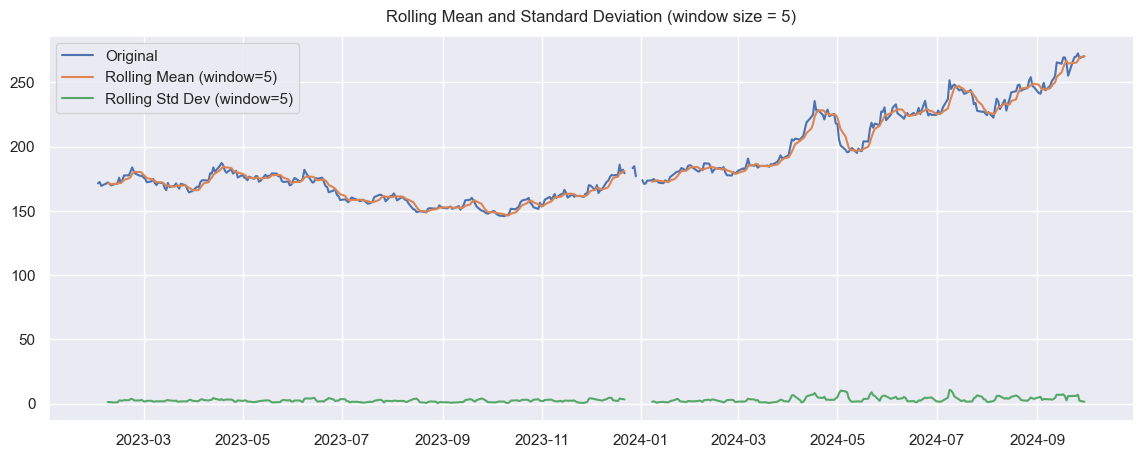

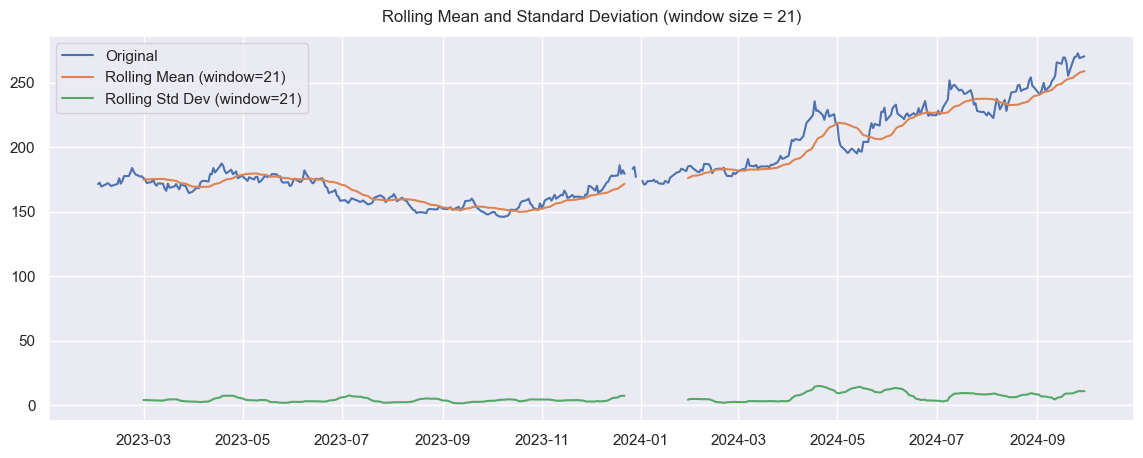

In [52]:
## Rolling Statistics at different periods
window_sizes = [5, 21, 63]  # A week, a month, a quarter,  (approximately)
data_rolling = icip_df['I-CIP']  

for window in window_sizes:
    rolling_mean = icip_df['I-CIP'].rolling(window=window).mean()
    rolling_std = icip_df['I-CIP'].rolling(window=window).std()
    
    plt.figure(figsize=(14, 5))
    plt.plot(icip_df['I-CIP'].index, icip_df['I-CIP'], label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.plot(rolling_std.index, rolling_std, label=f'Rolling Std Dev (window={window})')
    plt.title(f'Rolling Mean and Standard Deviation (window size = {window})')
    plt.legend()
    plt.show()

### checking for missing dates for determine the right frequency


from ealier sections, it was observed that there were 100 days missing from the 365 window of dates whithin the dataset. However,  since this dataset displays data from monday-friday (business days) it was "assumed" (in data science we cant make assumptions but still...) that those 'missing' dates were only referent to weekends and/or holidays. This code below extracs the exact dates missing from the entire range for business days.



In [55]:
# Generate a date range for 366 days from the start of your data
# Adjust the period accordingly if you have data spanning multiple years or a different time frame
start_date = icip_df.index.min()
end_date = icip_df.index.max()  


# Generate a range of business days within this period
business_days = pd.bdate_range(start=start_date, end=end_date)

# Now compare the business_days with your DataFrame's index to find out missing dates
missing_dates = business_days.difference(icip_df.index)

print(f"Total number of expected business days: {len(business_days)}")
print(f"Total number of actual days in data: {icip_df.shape[0]}")
print(f"Total number of missing dates: {len(missing_dates)}")
print("Missing dates are:")
print(missing_dates)

Total number of expected business days: 434
Total number of actual days in data: 434
Total number of missing dates: 0
Missing dates are:
DatetimeIndex([], dtype='datetime64[ns]', freq='B')


# 3. Modelling